# Learning Machine Learning

*This worksheet was originally designed by [Erin George](https://www.math.ucla.edu/~egeo/) (Department of Mathematics, UCLA). It has been subsequently revised by later TAs and instructors.*

Today we're going to take the time to review the basic concepts for machine learning models.  Some of you might have seen this in PIC16A or somewhere else, some of you might have not.  That's okay!  We're going to go through things from the top and fill in the details you might be missing.  Throughout this worksheet, I'll be introducing a lot of vocabulary that might be new to you.  These will be written in **bold**.  Don't worry about memorizing them, we're not going to ask you to repeat the definitions on an exam!  However, by the end of the course, you should be comfortable using this vocabulary if you aren't already.

Let's first discuss the basic setting of machine learning.  The basic idea is that there is some pattern that exists in our dataset that we want our computer to learn.  We will do this by creating a **model**.  There are two main types of problems:

1. We want our program to learn *groups* in the data.  For example, our dataset could be "images that contain traffic lights" and "images that do not contain traffic lights" (hi Google!).  We want our model to be able to take new data and identify what group it belongs.  In our example, we would want to be able to supply our program with a new image and have it tell us whether or not contains a traffic light.  This type of problem is often called **classification** and the groups are often called **classes**.
2. We want our program to learn *values* in the data.  The values here should not just be integers, but also include decimals (i.e., real numbers).  We want our model to be able to predict what this value would be when it sees new data.  For example, our data could be a list of attributes (age, weight, etc.) about an animal and we are concerned about its height.  In this example, we would want to be able to take to get information about a new animal and be able to guess its height.  This problem is often called **regression**, although I think that term is a little less common than "classification" is.  If you are familiar with mathematical terminology, this is often described as there being some function on the data and we want to learn how to evaluate the function.

The distinction between these two problems is important, because the types of models that we can use to solve them are completely different.  Fortunately, the general process to set up an accurate model is more or less the same.  The outline for this process is this:

1. We prepare the data.  This is called **pre-processing**.
2. We prepare the model.  There isn't really a name for this process, but you might hear **building** to refer to this.
3. We give data to the model for it to learn from.  This is called **training**.
4. We see how well the model performs on new data.  This is called **testing** or evaluation.

The way models work is that they are predicting some piece of information (the value or class above) from given information in our dataset.  The information we are trying to predict is called the **labels** and the information we are given is called the **features**.  In training, the model has access to the labels and the features and attempts to learn how to predict the labels from the features.  In testing, the model only has access to the features and comes up with labels on its own.  We then see how accurate the predicted labels are compared to the true labels to evaluate how good our model is.

Now, let's go with an example problem to go through these steps.  We will be using the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

Before we start pre-processing, it's always a good idea to look at the dataset we're using.  This will help us understand how the data is set up and what problem we want to be solving.

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()

What is this dataset?  When we look at the wikipedia article for MNIST, we see that it is a dataset of *images*.  Let's take a look at how it's stored.  We get four different NumPy arrays when we load MNIST.  For now, let's just worry about `x_train`.  The others will be explained later.

In [2]:
x_train.shape

(60000, 28, 28)

The `x_train` variable is a 3D NumPy array of size 60000 x 28 x 28.  In a machine learning dataset, the convention is that all information that share the same first index represents the same "point" in the dataset.  As an example, here it means that the NumPy array `x_train[0,:,;]` represents the first image in the dataset.  Let's take a look at it.

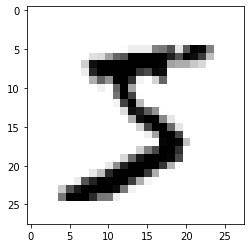

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0,:,:], cmap='binary')
plt.show()

We get an image that looks like the number 5.  Great!  The MNIST dataset contains images that all depict one digit between 0 and 9.  Our goal is to figure out what digit each image shows.  What type of problem is this?

Well, it might sound like it's a regression problem, since we are trying to get a number.  However, regression problems are supposed to be *continuous*, which means that we want our valid answers to be *any* real number, at least within a certain range.  Here, we want our numbers to be between 0 and 9, but an answer like "4.5" is not going to be a sensible answer.  Since there are only ten different digits it could be, this is actually a classificaiton problem.

Now that we've identified our problem, let's continue.  We want to do one more thing, which is set the random seed for NumPy.  This is so that if we run our code more than once, we will get the same results.

In [4]:
import numpy as np

np.random.seed(184)

## Pre-processing

In pre-processing, we prepare our data so that our model can use it.  There are a lot of things we might want to do during pre-processing, but the two most important are to *clean* and *split* the data, which should also be done first.

The very first thing we should do is **clean** the data, which is to rfix wrong and missing data in it.  In our data, we don't need to clean anything.  But it's always good to check first.  If there is any value in your dataset that is obviously wrong, remove it.  Usually these are absurd numbers, such as a person's height being recorded as 60 feet or as -1 feet.  Sometimes this will be a mislabeled categorical variable, such as a penguin's sex being recorded as "." (as some might remember from PIC16A).  There will also likely be missing data, which might be recorded in the data as None or NaN.  Sometimes a blank spot is recorded as an empty string or as -1, but only if these aren't also valid values for that feature to be.

If there's a missing or incorrect value in the data, there are three options to deal with it:
1. Leave it blank.  Some models can deal with missing data.  Most can't, so this is rarely an option.  But if our model can, then all we need to do to clean your data is blank out the incorrect values.
2. Remove the entire row (i.e, the entire data point).  This is usually the correct choice.
3. Remove the entire column (i.e., the entire feature).  This is what we should do if a feature has a lot of missing values.  Generally, we have more points than features, so removing a feature hurts more than removing a point.  However, it's usually not worth cutting the number of points you can use in half just to keep one extra feature.

Once we finish cleaning our data, we want to split it.  The first split we want to do is to remove the labels from the features.  Generally we call the data containing the features `x` and the data containing the labels `y`.  We can see that this is already done in our dataset, but in general we'd have to do ourself.  This is usually done by just getting a column from the dataset as the labels and removing it from the dataset to get the features.

Next, we want to split the data into either two or three sets, depending.  These are:
1. The **training set**.  This will contain most of the data and it the data the model will learn from.
2. The **test set**.  This is what we will use to evaluate the final accuracy of the model after it's finished.  (You might hear this be called a **hold-out set**, it's the same thing.)
3. Sometimes we use a **validation set**.  Like a test set, this is used to evaluate the accuracy of the model after it's been trained.

We split our data to protect against **overfitting**.  An easy way to evaluate the model is to see how well it can generate labels on the data it was trained on.  However, the model could have learned *any* way to tell the labels from the features.  It could have learned the pattern we were looking for or it could have learned some other, likely more subtle and spurious, pattern.  For example, maybe in our dataset for MNIST all the "5" images have a dark pixel in exactly one spot.  The model learns this and gets very good accuracy, but this is not a useful way to determine a number in a general setting.  Splitting the data allows us to see how well a model on data it didn't see during training.

So why would we want two sets?  Well, if we're making a model, we want it to do well on the test set.  If we make a model that does poorly on the test set, we're going to change our model a bit so it does better.  We keep doing this until the model does well on the test set, and then we're satisfied.  This sounds great, but unfortunately, can result in the model "learning" from the test set in a very subtle way.  To prevent this, we test our intermediate models on a validation set (which we don't have to keep the same for each new model) until we are satisfied.  Then we get a final accuracy on a the test set, which we have never used before.

As an alternative to creating an explicit validation set, we can do **cross-validation**.  This is when we create multiple train/validation set pairs from the training set and compares the model on all of these pairs.  Scikit-learn provides a method to do this for its models.

(There is an issue in terminology: sometimes "validation set" and "test set" get switched and mean the opposite of above.  We won't do that in this course, though.  Also, sometimes you might hear **development set** (**dev set**), which only ever means what we call a validation set.)

We can use the Scikit-learn method `train_test_split` to create the test (and validation) set.  Our data already has a train/test split, but let's make a train/validation split in it as well.  This method also shuffles the data by default, which is useful.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train)

The size of your test set and validation set can vary.  By default, `train_test_split` makes this 25% of your data, which is fine.  We can see that our data already has a test set that is 1/7 of the entire dataset, which is about 14%.  This is fine too.  Some proportion close to these is good: there's no real rule about what it has to be.  I like to do 20%, myself.

You can split the data into features/labels and train/test in either order.  If you split into features/labels first, make sure your train/test split is the same for both parts.  We want a row in `x_train` to correspond to the row in `y_train` with the same index.  Don't do this:

In [ ]:
# incorrect!
x_train, x_test = train_test_split(x) # x here is our features
y_train, y_test = train_test_split(y) # y is our labels

That makes the test set different for the labels and the features, which will destroy the connection between them.

(One last note on splitting: if you have classes in your data (either in the labels or the features), you might want to split to make sure every class appears in the training set.  There are methods to do this.  This is mostly an issue if one of the classes is particularly rare.  In our case, it's very unlikely that a class is going to be missing in the training set, so it's okay.)

Beyond splitting, there's other things we might want to do to preprocess the data.  In our data, we can see that each "row" of the data actually has two dimensions.  This is useful in some models, but not for any of the models we know about now.  We're going to reshape the data so that each row just has 784 features.

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

Two of the most common pre-processing techniques are to **standardize** quantitative features (numbers) and to **encode** categorical features (classes, descriptions).

When we standardize features, we modify them so they have mean 0 and standard deviation 1 in the training set.  We can think of this as just changing the units on the features.  This prevents the model from thinking one feature is more significant than another just because the numbers are larger (this actually happens!).

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

We don't have any categorical features, so we don't have anything to encode.  If we did, we would want to use Scikit-learn's `LabelEncoder` or `OneHotEncoder`.  These turn the categorical into numbers so that models can understand them.  They work in different ways and might have different impacts on your model.  Try them both if you ever need to use categorical features!

## Building the Model

Now, we build the model.  There's very little to do here, especially if you use Scikit-learn!  All we need to do is load the model.  For example, let's do a variant of SVM (Support Vector Machine) model.

In [8]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter = 10)

All done!

Here's when we would input and toy with the various attributes of your model that we don't train (the so-called **hyperparameters**).  These are going to be the parameters of the model's initializer, and include things such as "complexity" and learning rate.  Every model has different hyperparameters, and changing these can give us better or worse results.  We can try a bunch of different hyperparameters and take the model that does the best on the validation set.

Here we set the the `max_iter` hyperparamter to 10.  This makes our model worse, but makes it train faster.

## Training the Model

After we've built the model, we want to train it.  All Scikit-learn models are trained the same way.

In [9]:
model.fit(x_train, y_train)

/home/erin/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(max_iter=10)

Our model gives us an error when we train it.  This is because we didn't allow the model to run fast enough for it to converge, which means it never stabilized.  This is a problem, but not a huge one.  We can fix this by increasing the `max_iter` hyperparameter, but then the training would take longer than we have right now.

## Testing the Model

Lastly, we test the model.  The first thing we should do is see how the model performs on the training set.  This number is not as important as the accuracy on the validation or test sets, but it's a nice measure to have.  In particular, if our accuracy on the validation set is not so good, the accuracy on the training test let's us know what's wrong with the model.  If the accuracy on the training set is high, this means our model was overfitting on the training set.  We should fix this by reducing the complexity of the model or the length of time it was being trained.  If the accuracy on the training set is low, this means our model failed to learn the pattern it was supposed to.  We should fix this by increasing the complexity of the model or the length time it was being trained.

In [10]:
sum(y_train == model.predict(x_train))/len(x_train)

0.919

The accuracy is above 90%, which is pretty good!  We could do better with a different model, but this is a good first start.  Now we look at the validation set.  Our hope is the accuracy is pretty much the same.  If it's less, that means we overfitted the model on our data.  If it's more... that's weird, but not really a problem.

In [11]:
sum(y_valid == model.predict(x_valid))/len(x_valid)

0.9108

The accuracy dropped a little bit.  This is to be expected.  However, it didn't drop a whole lot, so that's great!  It looks like we didn't overfit our model, and it generalized well to new data.  Because of this, we have no reason to go back and change our model, so we can go ahead and evaluate it on our test set to get our final accuracy.

In [12]:
sum(y_test == model.predict(x_test))/len(x_test)

0.9137

Again, a little worse than the training set accuracy, but still above 90%.  At this point, since we already evaluated it on our test set, we shouldn't go back and make changes to our model.